
Model Performance:
Logistic Regression: (0.75625, 0.7745664739884393, 0.04709315299987793)
SGD Classifier: (0.690625, 0.7455012853470437, 0.019366979598999023)
Ridge Classifier: (0.765625, 0.7875354107648725, 0.07551717758178711)


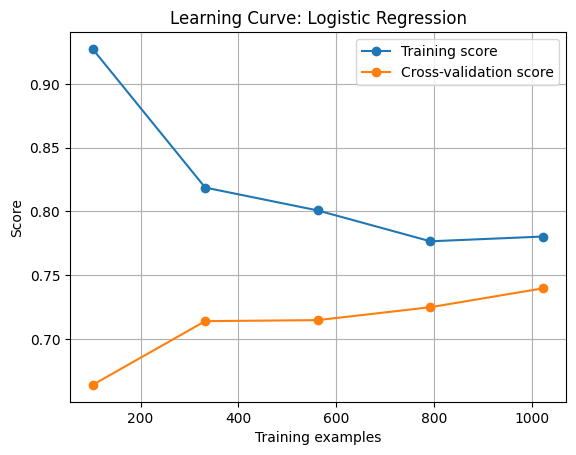

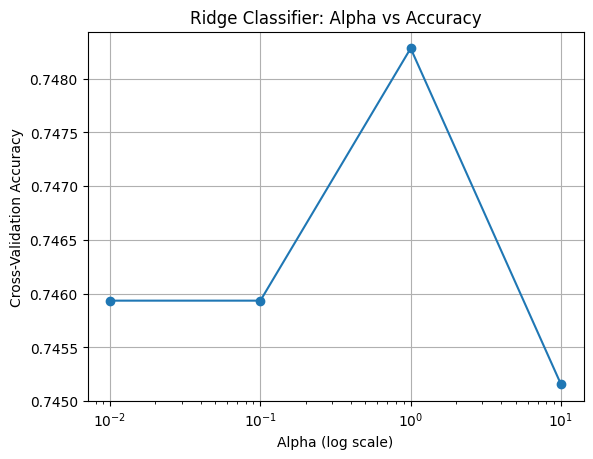


Best Ridge Alpha: {'alpha': 1.0}
Best Accuracy Score: 0.74828125


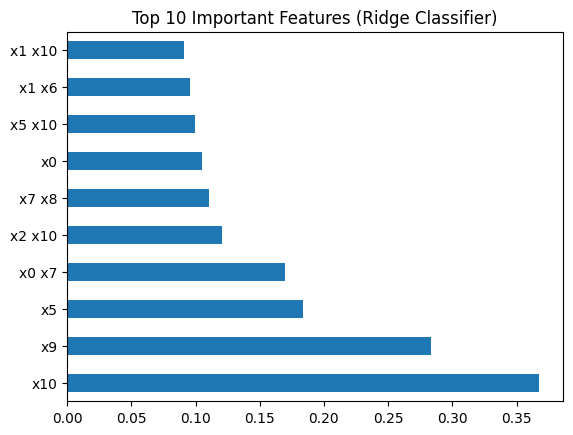

In [8]:
# Task 02: Model Training Fundamentals with Custom Dataset

# Part 1: Imports and Dataset Loading
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Dataset Example: Wine Quality (UCI ML Repository)
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')

# Part 2: Data Preprocessing
X = data.drop("quality", axis=1)
y = (data["quality"] >= 6).astype(int)  # Binary classification: good(1) vs bad(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Part 3: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Part 4: Model Training & Evaluation
def evaluate_model(model, X_tr, X_te, y_tr, y_te):
    start = time.time()
    model.fit(X_tr, y_tr)
    end = time.time()
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    return acc, f1, end - start

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SGD Classifier": SGDClassifier(max_iter=1000, loss='log_loss', penalty='l2'),
    "Ridge Classifier": RidgeClassifier(alpha=1.0)
}

results = {}
for name, model in models.items():
    try:
        results[name] = evaluate_model(model, X_train_poly, X_test_poly, y_train, y_test)
    except Exception as e:
        results[name] = str(e)

print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")

# Part 5: Learning Curve

def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5,
                                                            scoring='accuracy',
                                                            train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(LogisticRegression(max_iter=1000), "Learning Curve: Logistic Regression", X_train_poly, y_train)

# Part 6: Hyperparameter Tuning (Grid Search)
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}
ridge = RidgeClassifier()
grid_search = GridSearchCV(ridge, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_poly, y_train)




# Part 6.1: Visualize all alpha results
alphas = param_grid['alpha']
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure()
plt.plot(alphas, mean_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Ridge Classifier: Alpha vs Accuracy')
plt.grid(True)
plt.show()

print("\nBest Ridge Alpha:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)

# Part 7: Feature Importance
ridge_best = grid_search.best_estimator_
coefs = pd.Series(ridge_best.coef_, index=poly.get_feature_names_out())
coefs.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Important Features (Ridge Classifier)")
plt.show()